# Intro Data Science Industry Final Project
## George Austin, gia2105
### Predicting taxi trip times

In [1]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import datetime
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing


pd.set_option('display.max_columns', 500)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/george/Downloads/My First Project-8d2170533b7e.json"
client = bigquery.Client()

/Users/george/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### The cells below do the SQL Big Query operations

#### Some ideas for datasets to join into the Big Query stuff:
1. Weather
2. Traffic collision data (this might be hard, but collisions do increase traffic ==> therefore triptime. This was done by rounding the collison times up to the nearest hour, and adding a column in the trip times for rounding the start times down to the nearest hour, to ensure there was no future information being used. 
3. maybe find a list of days where traffic is stopped, like due to holidays, marathons... 

## Here's a quick summary of the preprocessing steps taken in the SQL query below:
1. Decided to only incorporate cab rides that laster between 30 and 6500 seconds, decided anything that didnt fall under this category was probably an error in the reporting. 
2. Made sure the pickup and dropoff sports are not NULL
3. made sure the locations were between 30 and 50 latitude, and -65 and -80 longitude. This is roughly the zone that new york is in, and there are a few zeros in the dataset that should be filtered out

## Some variables that were taken into account

1. took the travel time, as that is the value to predict
2. rounded the time to the nearest hour, this was part of my efforts to make it easier ot join this dataset with collision/citibike information, though the results didnt seem to help the models much :(  
3. Extracted the day of the week as weekday, as I thought this could be relevant, as I know, for example, that traffic on Friday afternoons getting out of the city (weekend commuters) is usually much worse than on Sunday afternons. This didn't seem to have as much of an impact on the taxicab data as I thought it would.
4. Used the ST_DISTANCE function to get the distances, both euclidean and manhattan. 
5. combined the data with the taxi geometry data as one way to split the locations up. I also look into k-means and EM approaches further down. These clusters were explore by to trying to combine with the collision data, as well as just seeing how they worked as predictive tools on their own. 
6. Left joined with the weather data, most of those variables didn't seem to offer too much information. prcp seemed to do the best, and some variables did need some further preprocessing (for example, some columns had values that defauls to 999.99)
7. When loading the collision data, I rounded up to the nearest hour so that I could join by the rounded to the hour time of the trip data, so I needed to ensure I would bne making predictions on future information. It is possible that by doing this, I lost the most relevant information, but other approaches took to long to execute.


In [2]:
#SQL QUERY THAT MATHCES BOROUGH TO PICKUP LOCATION and DROPOFF AND INCLUDES WHEATHER DATA
query = (
     '''SELECT * FROM
(
SELECT pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
    TIMESTAMP_TRUNC(timestamp_sub(pickup_datetime, INTERVAL 60 - EXTRACT(MINUTE from pickup_datetime)  MINUTE),
            HOUR) as rounded_time,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (DAY FROM pickup_datetime) as day_of_year,
     EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
     EXTRACT (YEAR FROM pickup_datetime) as year_of_year,
     EXTRACT (DAYOFWEEK FROM pickup_datetime) as weekday,
     ST_DISTANCE(
         ST_GeogPoint(trips.pickup_longitude, trips.pickup_latitude),
         ST_GeogPoint(trips.dropoff_longitude, trips.dropoff_latitude)) as euclid_distance,  
     ST_DISTANCE(
         ST_GeogPoint(trips.pickup_longitude, trips.pickup_latitude),
         ST_GeogPoint(trips.dropoff_longitude, trips.pickup_latitude)) +
         ST_DISTANCE(
         ST_GeogPoint(trips.dropoff_longitude, trips.pickup_latitude),
         ST_GeogPoint(trips.dropoff_longitude, trips.dropoff_latitude)) 
         as manh_distance ,
     start_zones.borough as pickup_borough,
     start_zones.zone_id as pickup_zone, 
     end_zones.borough as dropoff_borough,
     end_zones.zone_id as dropoff_zone
 FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` as trips,
  `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` as start_zones,
  `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` as end_zones
WHERE 
   (TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) BETWEEN 30 AND 6500) AND
    pickup_longitude IS NOT NULL AND
    pickup_latitude IS NOT NULL AND
  (pickup_latitude BETWEEN 30 AND 50) AND
  (pickup_longitude BETWEEN -80 AND -65) AND
  (dropoff_latitude BETWEEN 30 AND 50) AND
  (dropoff_longitude BETWEEN -80 AND -65) AND
ST_Intersects(
  (start_zones.zone_geom),
  ST_GeogPoint(trips.pickup_longitude, trips.pickup_latitude))
  and ST_Intersects(
  (end_zones.zone_geom),
  ST_GeogPoint(trips.dropoff_longitude, trips.dropoff_latitude))
)

LEFT JOIN
    (
     SELECT concat(year,'-',mo,'-',da) as date_of_year2, visib, prcp,sndp,fog,rain_drizzle
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) 
    on date_of_year2 = CAST( EXTRACT(DATE FROM pickup_datetime) as string )
ORDER BY RAND()
LIMIT 1000000
'''
)
    
df_raw=pd.io.gbq.read_gbq(query,dialect='standard')

print('done!') 



done!


In [3]:
#Importing Traffic collision data. will need to do creative thigns to make a (boolean) column for whether or not there
#was a traffic collision on the taxi path, (has to be before, can't be going off future information)

query = (
    
  """
SELECT
timestamp as time, 
timestamp_trunc(timestamp_add(timestamp, INTERVAL 60 - EXTRACT(MINUTE from timestamp)  MINUTE) , HOUR) as rounded_time , latitude, longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE timestamp >= '2015-12-31 23:30:00' and timestamp <= '2016-07-13 23:30:00' and latitude IS NOT NULL
AND (latitude BETWEEN 30 AND 50) AND
  (longitude BETWEEN -80 AND -65) 
order by time
""" 
)

collision = pd.io.gbq.read_gbq(query,dialect='standard')


print('done!')

done!


In [4]:

df  = df_raw

df[['pickup_zone']] = df[['pickup_zone']].astype('float64')
df[['dropoff_zone']] = df[['dropoff_zone']].astype('float64')

df = df.dropna()
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,rounded_time,date_of_year,day_of_year,month_of_year,year_of_year,weekday,euclid_distance,manh_distance,pickup_borough,pickup_zone,dropoff_borough,dropoff_zone,date_of_year2,visib,prcp,sndp,fog,rain_drizzle
0,2016-05-05 21:11:59+00:00,-73.987160,40.750660,-73.978554,40.762569,240,2016-05-05 20:00:00+00:00,2016-05-05,5,5,2016,5,1509.684663,2049.213614,Manhattan,100.0,Manhattan,163.0,2016-05-05,9.5,0.01,999.9,0,0
1,2016-06-25 15:52:08+00:00,-73.991364,40.755013,-73.978394,40.752342,729,2016-06-25 15:00:00+00:00,2016-06-25,25,6,2016,7,1132.128268,1389.398693,Manhattan,100.0,Manhattan,170.0,2016-06-25,9.2,0.00,999.9,0,0
2,2016-02-09 09:39:43+00:00,-73.983513,40.735027,-74.014259,40.712307,784,2016-02-09 09:00:00+00:00,2016-02-09,9,2,2016,3,3618.851673,5116.978637,Manhattan,107.0,Manhattan,13.0,2016-02-09,9.4,0.05,999.9,0,0
3,2016-01-28 20:28:47+00:00,-74.009842,40.709671,-73.948746,40.780891,1106,2016-01-28 19:00:00+00:00,2016-01-28,28,1,2016,5,9444.967035,13069.070710,Manhattan,87.0,Manhattan,263.0,2016-01-28,10.0,0.00,9.1,0,0
4,2016-01-01 15:04:53+00:00,-73.982460,40.742756,-73.957832,40.722504,977,2016-01-01 14:00:00+00:00,2016-01-01,1,1,2016,6,3062.251129,4326.749535,Manhattan,170.0,Brooklyn,255.0,2016-01-01,10.0,0.03,999.9,0,0


In [6]:
#dropping the columns that are either irrelevant or would contribute to information leakage

#making a column marking the hour in the day, which should have an impact on the expected traffic
df['hour'] = df['pickup_datetime'].dt.hour
#now making a column of the time of day by minute, i.e. hour*60 + minute
df['total_minutes'] = df['pickup_datetime'].dt.hour*60 + df['pickup_datetime'].dt.minute


#adding a is_rush_hour variable, defining rush hour as hours 7-9 and 4-6
#also remebering to ajust from UTC time to eatern time (adding four hours), more for linear data
rush_hours = pd.DataFrame([7,8,9,16,17,18])
rush_hours = rush_hours + 4
df['is_rush_hour'] =  df['hour'].isin(rush_hours)


df['pickup_in_manh'] = df['pickup_borough'] == 'Manhattan'
df['dropoff_in_manh'] =  df['dropoff_borough'] == 'Manhattan'

np.shape(df)



(1000000, 29)

## Now, on to the exploratory data analysis/Model Testing

### Here is a function that does a test train split on a specified set of columns on a dataset, fits it to a specified sklearn model, and then does a linear (or polynomial) fit on the residuals from the training data. Also returns a plot of feature importance, as well as the linearly adjusted model's performace on the test split of the data.
### This function makes it easy to play around with different variablees, as well as different sklearn functions/features.

train r squared: 0.7330039367011472
test R squared: 0.7315825627634889
test RMSE: 332.9474760535722
test RMSLE: 0.40725836352296557
None
1. feature 0 (0.316752)
2. feature 3 (0.256125)
3. feature 2 (0.121761)
4. feature 6 (0.104120)
5. feature 7 (0.092204)
6. feature 5 (0.076150)
7. feature 4 (0.028001)
8. feature 1 (0.004887)


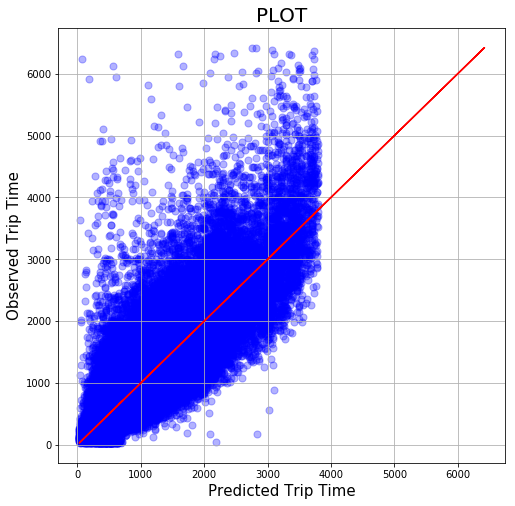

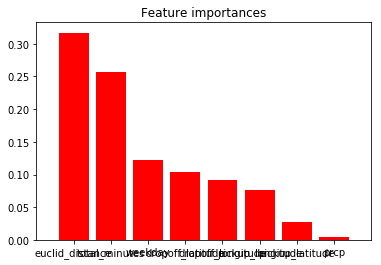

None
train r squared: 0.9551974726272744
test R squared: 0.7717059035535703
test RMSE: 307.056082490766
test RMSLE: 0.37355428144497704
None
1. feature 0 (0.669713)
2. feature 3 (0.100182)
3. feature 6 (0.053693)
4. feature 7 (0.049096)
5. feature 5 (0.047731)
6. feature 4 (0.038697)
7. feature 2 (0.029884)
8. feature 1 (0.011004)


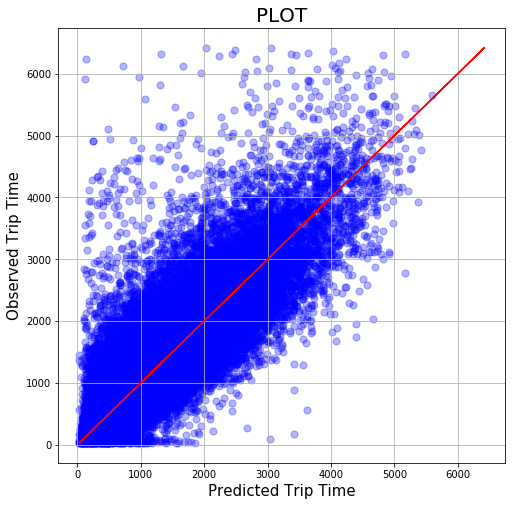

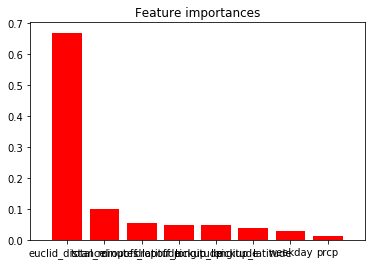

None


In [7]:
#here are some of the columns that i've tried using for both random forest and gradient boosting
#both generally do well, with the column at the bottom that is actually used being the best performing one
#Still, random forest generally does slightly better

#X = df[['dropoff_latitude', 'total_minutes', 'manh_dist', 'euclid_dist','weekday']]
#X = df[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude', 'pickup_zone', 'dropoff_zone', 'weekday', 'total_minutes']]
#X = df[['euclid_dist','manh_dist', 'pickup_zone', 'dropoff_zone', 'weekday', 'total_minutes', 'month_of_year']]

#X = df[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude', 'total_minutes', 'dropoff_zone', 'pickup_zone', 'month_of_year']]

#X = df[['pickup_zone', 'dropoff_zone','weekday', 'total_minutes', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']]


#columns = [ 'total_minutes', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']

def linear_adjust(function, df, columns, deg):
    y = df['travel_time']
    X = df[columns]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    fit = function.fit(X_train, y_train)
    fit_pred = fit.predict(X_train).reshape(-1, 1)
    
    model = LinearRegression(fit_intercept = True)
    
    #adding a 2nd order polynomial fit to capture the dip in the trend
    regr = model.fit( PolynomialFeatures(degree = deg).fit_transform(fit_pred), y_train )
    #regr = model.fit(fit_pred, y_train)
    
    test_pred = regr.predict(PolynomialFeatures(degree = deg).fit_transform( fit.predict(X_test).reshape(-1,1)))
    #test_pred = fit.predict(X_test)
    test_pred[ test_pred <= 20 ] = 45
    
    print 'train r squared:', r2_score(y_train, regr.predict(PolynomialFeatures(degree=deg).fit_transform(fit_pred)))
    #print r2_score(y_train, fit_pred)
    print 'test R squared:', r2_score(y_test, test_pred) 
    
    print 'test RMSE:', np.sqrt(mse(y_test, test_pred)) 
    print 'test RMSLE:', np.sqrt( msle(y_test, test_pred))


    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Predicted Trip Time', fontsize = 15)
    ax.set_ylabel('Observed Trip Time', fontsize = 15)
    ax.set_title('PLOT', fontsize = 20)
    ax.scatter(test_pred, y_test, s = 50, alpha = .3, color = 'blue')
    ax.plot( y_test, y_test, color = 'red')
    print ax.grid()
    
    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]


    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    


    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r")#, yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), [ columns[i] for i in indices ])
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    
    
 



#columns = ['pickup_cluser', 'dropoff_cluser', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude', 'total_minutes']#, 'pickup_zone', 'dropoff_zone']

columns = ['euclid_distance','prcp', 'weekday', 'total_minutes', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']
#colums = ['pickup_zone', 'dropoff_zone','euclid_dist','manh_dist', 'weekday']
deg = 1

print linear_adjust(GradientBoostingRegressor(), df, columns, deg)
print linear_adjust(RandomForestRegressor(n_estimators = 10, max_depth = 30), df, columns, deg )



    

## Plan Moving Forward:
- look into finding a way to join collision dataset with the main data
    probably the best way to do it is through the zone_id label, end goal being to know how many collisions happened in a zone during the previous thirty minutes
    Ended up doing this using the ids, kmeans and EM. None of these methods turned out to help the models
- add a column for wether or not a day is gridlock alert day in nyc
       if no better solution just manually input the days for years 2015-2017, could just do this in python
       It turns out that for all months greater thhan 6, the latitude and longitude are NULL in the SQL dataset, so this doesn't even apply, since stuff like the UN meetings, thanksgiving/holiday traffic are all in the later months. 

In [7]:
df.head()['pickup_datetime'].dt.date == datetime.date(2016, 5, 28 )

0    False
1    False
2    False
3    False
4    False
Name: pickup_datetime, dtype: bool

In [8]:
gridlock_alert_days = []
gridlock_alert_days.append( datetime.date(2016, 11, 18) )
gridlock_alert_days.append( datetime.date(2016, 11, 23) )
gridlock_alert_days.append( datetime.date(2016, 11, 30) )
gridlock_alert_days.append( datetime.date(2016, 12, 9) )
gridlock_alert_days.append( datetime.date(2016, 12, 14) )
gridlock_alert_days.append( datetime.date(2016, 12, 15) )
gridlock_alert_days.append( datetime.date(2016, 12, 16) )
gridlock_alert_days.append( datetime.date(2016, 12, 21) )
gridlock_alert_days.append( datetime.date(2016, 12, 22) )
gridlock_alert_days.append( datetime.date(2016, 12, 23) )

gridlock_alert = pd.DataFrame(gridlock_alert_days)

In [9]:
df[df['month_of_year'] >6]#datetime.date(2016, 11, 2) ]  #.isin(gridlock_alert) )

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,rounded_time,date_of_year,day_of_year,month_of_year,year_of_year,weekday,euclid_distance,manh_distance,pickup_borough,pickup_zone,dropoff_borough,dropoff_zone,date_of_year2,visib,prcp,sndp,fog,rain_drizzle,hour,total_minutes,is_rush_hour,pickup_in_manh,dropoff_in_manh


## Looking into k-means and EM clustering, as a way to incorporate the collision data, and just to see if they help on their own

In [10]:
spots = df[['dropoff_longitude', 'dropoff_latitude']]


/Users/george/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


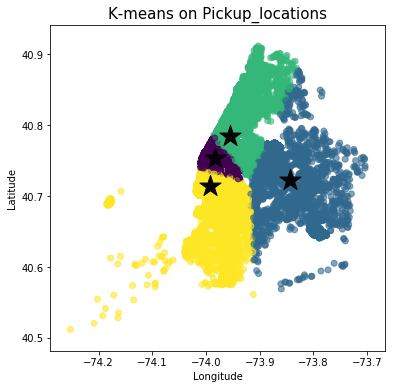

In [11]:
from sklearn.cluster import KMeans

K = 4 # change K to whatever number of clusters you want
kmeans_model = KMeans(n_clusters=K)

# perform K-means 
kmeans = kmeans_model.fit(spots)

#get the cluster lables
labels = kmeans.predict(spots)

# Get cluster center positions for each cluster.
# This will just be the x,y coordinates for X_example.
centers = kmeans.cluster_centers_

#plot the clusters
plt.figure(figsize=(6, 6))
plt.title('K-means on Pickup_locations', fontsize=15)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.scatter( spots['dropoff_longitude'], spots['dropoff_latitude'], c=labels, alpha = 0.6 )
plt.scatter([c_x[0] for c_x in centers], [c_y[1] for c_y in centers], marker='*', c='#050505', s=500)
plt.show()

In [12]:
df['dropoff_cluster'] = labels
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude']])

In [13]:
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,rounded_time,date_of_year,day_of_year,month_of_year,year_of_year,weekday,euclid_distance,manh_distance,pickup_borough,pickup_zone,dropoff_borough,dropoff_zone,date_of_year2,visib,prcp,sndp,fog,rain_drizzle,hour,total_minutes,is_rush_hour,pickup_in_manh,dropoff_in_manh,dropoff_cluster,pickup_cluster
0,2016-05-25 15:32:35+00:00,-73.825653,40.712212,-73.885490,40.738098,1093,2016-05-25 15:00:00+00:00,2016-05-25,25,5,2016,4,5806.171274,7921.868186,Queens,134.0,Queens,83.0,2016-05-25,9.0,0.03,999.9,0,0,15,932,False,False,False,1,1
1,2016-04-11 17:16:25+00:00,-73.999084,40.739292,-73.991447,40.731907,396,2016-04-11 16:00:00+00:00,2016-04-11,11,4,2016,2,1043.274179,1464.631558,Manhattan,90.0,Manhattan,113.0,2016-04-11,9.3,0.00,999.9,0,1,17,1036,False,True,True,3,0
2,2016-05-27 11:09:32+00:00,-73.953987,40.773125,-73.918625,40.815575,1106,2016-05-27 10:00:00+00:00,2016-05-27,27,5,2016,6,5580.511940,7698.017952,Manhattan,263.0,Bronx,159.0,2016-05-27,7.5,0.00,999.9,0,0,11,669,False,True,False,2,2
3,2016-05-23 10:08:53+00:00,-73.953812,40.784939,-73.980354,40.754009,1467,2016-05-23 09:00:00+00:00,2016-05-23,23,5,2016,2,4101.764776,5673.928943,Manhattan,236.0,Manhattan,161.0,2016-05-23,9.2,0.09,999.9,0,1,10,608,False,True,True,0,2
4,2016-06-20 20:33:22+00:00,-73.977310,40.758411,-73.962601,40.760700,495,2016-06-20 20:00:00+00:00,2016-06-20,20,6,2016,2,1264.782314,1493.438058,Manhattan,161.0,Manhattan,141.0,2016-06-20,8.9,0.00,999.9,0,0,20,1233,False,True,True,0,0


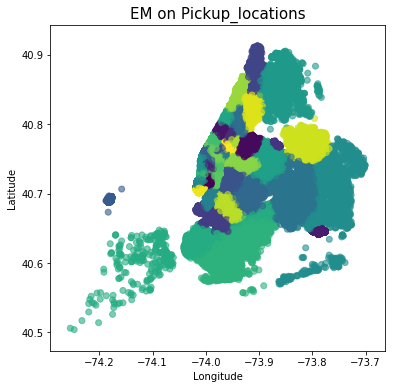

In [11]:
from sklearn.mixture import GaussianMixture

K = 40 # change K to whatever number of clusters you want
gauss_model = GaussianMixture(n_components=K)

# perform K-means 
gauss = gauss_model.fit(spots)

#get cluster lables
labels = gauss.predict(spots)

#plot the clusters
plt.figure(figsize=(6, 6))
plt.title('EM on Pickup_locations', fontsize=15)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.scatter( spots['dropoff_longitude'], spots['dropoff_latitude'], c=labels, alpha = 0.6 )
plt.show()

In [33]:
#df['dropoff_big_cluster'] = labels
df['pickup_gauss_cluster'] = gauss.predict(df[['pickup_longitude', 'pickup_latitude']])
df['dropoff_gauss_cluster'] = gauss.predict(df[['dropoff_longitude','dropoff_latitude']]) 





### Can see that both EM and K-means have some issues with splitting up the zones in a way that makes intuitive sense. This probably stems from the imbalance in the data, with most pickup or dropoff spots being in manhattan, that is where these algorithms need to make the zones. However, as we later see, most the biggest errors stem from the dropoffs outside manhattan, so splitting everything east of the river into one giant zone doesn't really help much. 

## Below is a plot of the zones from the taxi_zone_geom dataset. 

### I think, for the purposes of this project, these zones are a bit too small/specific, so it would be better to stick with K-means or EM instead. 

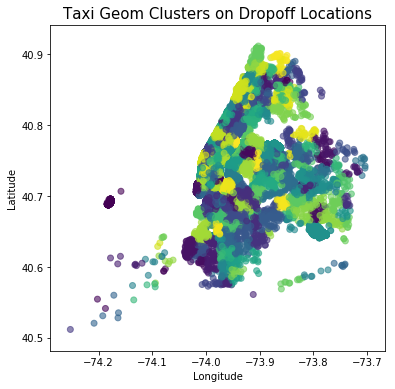

In [16]:
plt.figure(figsize=(6, 6))
plt.title('Taxi Geom Clusters on Dropoff Locations', fontsize=15)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)
plt.scatter( df['dropoff_longitude'], df['dropoff_latitude'], c=df['dropoff_zone'], alpha = 0.6 )
#plt.scatter( spots['dropoff_longitude'], spots['dropoff_latitude'], c=labels, alpha = 0.6 )
#plt.scatter([c_x[0] for c_x in centers], [c_y[1] for c_y in centers], marker='*', c='#050505', s=500)
plt.show()


## Here i'm combingin the colision dataset with the dropoff and pickup zones. It isn't the best way, but using geographies in the SQL query to get zones in between the pickup and dropoff spots too way too long to do, so I had to settle for this. 
## We see that the number of collisions in those zones don't actually help much. This was tried with both k-means and EM with a varying number of clusters. 

In [12]:
collision['cluster'] = gauss.predict(collision[['longitude', 'latitude']])
collision.head()

,time,rounded_time,latitude,longitude,cluster
0,2015-12-31 23:30:00+00:00,2016-01-01 00:00:00+00:00,40.680700,-73.844643,15
1,2015-12-31 23:40:00+00:00,2016-01-01 00:00:00+00:00,40.587305,-73.960349,25
2,2015-12-31 23:45:00+00:00,2016-01-01 00:00:00+00:00,40.656485,-73.960074,7
3,2015-12-31 23:50:00+00:00,2016-01-01 00:00:00+00:00,40.758429,-73.992633,12
4,2015-12-31 23:58:00+00:00,2016-01-01 00:00:00+00:00,40.823940,-73.948552,33


In [34]:
col = collision.groupby(by = ['rounded_time', 'cluster']).count().rename(columns = {'latitude':'dropoff_collisions'})['dropoff_collisions']
combined = pd.merge(df, col, how='left', left_on = ['rounded_time', 'dropoff_gauss_cluster'], right_on = ['rounded_time', 'cluster'] ).fillna(0)

col = collision.groupby(by = ['rounded_time', 'cluster']).count().rename(columns = {'latitude':'pickup_collisions'})['pickup_collisions']
combined = pd.merge(combined, col, how='left', left_on = ['rounded_time', 'pickup_gauss_cluster'], right_on = ['rounded_time', 'cluster'] ).fillna(0)


train r squared: 0.9504445712487996
test R squared: 0.7387526830061925
test RMSE: 328.9481118485057
test RMSLE: 0.3880084437406614
None
1. feature 2 (0.674806)
2. feature 3 (0.101218)
3. feature 6 (0.058591)
4. feature 5 (0.055772)
5. feature 7 (0.053619)
6. feature 4 (0.044667)
7. feature 0 (0.006039)
8. feature 1 (0.005289)


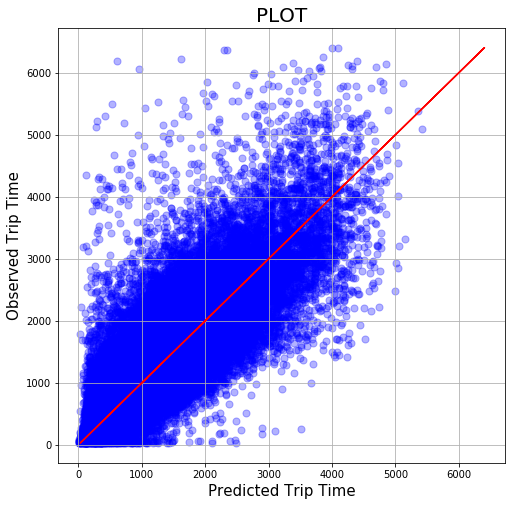

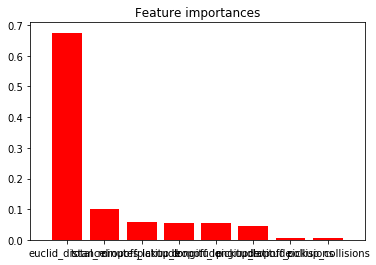

None


In [37]:


#columns = ['pickup_cluster', 'dropoff_cluster', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude', 'total_minutes']#, 'pickup_zone', 'dropoff_zone']
#visib, prcp,sndp,fog,rain_drizzle
columns = ['dropoff_collisions','pickup_collisions', 'euclid_distance','total_minutes', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']
#columns = ['pickup_gauss_cluster', 'dropoff_gauss_cluster', 'weekday', 'total_minutes']

deg = 1 
print linear_adjust(RandomForestRegressor(n_estimators = 10, max_depth = 30), combined, columns, deg )

#unfortunately, this collision data doesn't really help (they're are the far right of the feature importance plot)
#its too bad cause I put a lot of time and effort into getting that data in the mix, but oh well
    

## We can see that the collision data does not help. makign spefic filters in the SQL query, such as number of people killed >=1 or number of motorists injured >= also didn't help improve the performance.

## From the earlier RF model, we already have a pretty decent test score, although we can still see we have more outliers on the upper end than on the lower end, maybe we can search for some common factor.

In [20]:
y = df['travel_time']
#X = df[['dropoff_latitude', 'total_minutes', 'manh_dist', 'euclid_dist','weekday']]
#X = df[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude', 'pickup_zone', 'dropoff_zone', 'weekday', 'total_minutes']]
#X = df[['euclid_dist','manh_dist', 'pickup_zone', 'dropoff_zone', 'weekday', 'total_minutes', 'month_of_year']]

#X = df[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude', 'total_minutes']]#, 'dropoff_zone', 'pickup_zone']]#, 'month_of_year']]


columns = ['weekday', 'euclid_distance', 'total_minutes', 'pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']

 

X = df[columns]
#rf_clf = RandomForestClassifier(random_state=0, max_depth=30)
rf_clf = RandomForestRegressor(n_estimators = 100, max_depth = 30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_clf.fit(X_train,y_train)


print( rf_clf.score(X_test, y_test) )
print( rf_clf.score(X_train, y_train) )

0.7820315994514797
0.9679050566689504


/Users/george/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


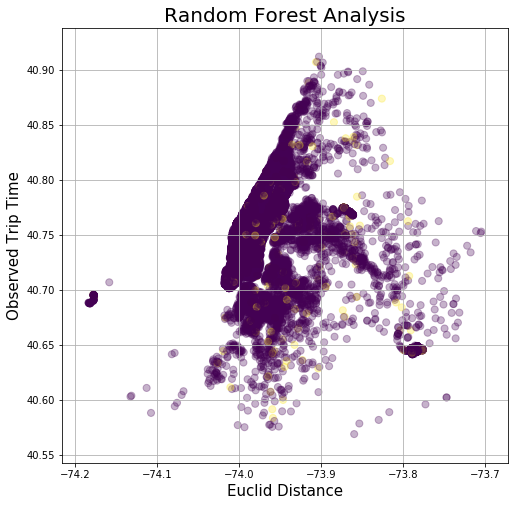

In [22]:
pred = rf_clf.predict(X_test).reshape(-1,1)[:]
#test = pd.DataFrame( X[:] )
#test['travel_time'] = y_test[:]
test = pd.DataFrame(y_test[:])
test['pred'] = pred
test['err'] = abs(test['pred'] - test['travel_time'])
#test.hist()
#test['bad_perf'] = test['err'] > 500

search = X_test[:]

X_test['bad_perf'] = test['err'] > 1000



fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Euclid Distance', fontsize = 15)
ax.set_ylabel('Observed Trip Time', fontsize = 15)
ax.set_title('Random Forest Analysis', fontsize = 20)
ax.scatter( X_test['dropoff_longitude'], X_test['dropoff_latitude'], s = 50, alpha = .3, c = X_test['bad_perf'] )
#ax.scatter(lin_data['is_rush_hour'],lin_data['travel_time'] )
#ax.plot( y_test, y_test, color = 'red' )
ax.grid()




Interestingly, the model seems to have more trouble when looking at cab rides outside of Manhattan. This intuitively makes sense, since tose trips are probabyl longer, and as we can see from k-means and EM, the data is dominated by trips in Manhattan. 

# Now looking to make a Linear Regression Model, as another possible approach

In [26]:
lin_data = df

In [27]:
lin_data = lin_data[['travel_time', 'is_rush_hour','dropoff_gauss_cluster', 'euclid_distance', 'manh_distance', 'weekday', 'total_minutes', 'hour', 'prcp']]

In [64]:
#making sin and cos of the total_minutes variable to capture cyclic trends in the data
lin_data['sin_time'] = np.sin( (100/1440) +  2*np.pi*lin_data['total_minutes'] / 1440 )
lin_data['cos_time'] = np.cos( (100/1440) + 2*np.pi*lin_data['total_minutes'] / 1440 )


/Users/george/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/george/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
Xlin = lin_data[['euclid_distance','sin_time', 'cos_time']]
ylin = lin_data['travel_time']

Xlin_train, Xlin_test, ylin_train, ylin_test = train_test_split(Xlin, ylin, test_size=0.2, random_state=42)


model = LinearRegression(fit_intercept = True)
regr = model.fit(Xlin_train, ylin_train)

print( regr.score(Xlin_test, ylin_test) )

print regr.coef_
#print regr.intercept_



0.6256557513932208
[   0.13232756 -100.00323602 -128.00647709]


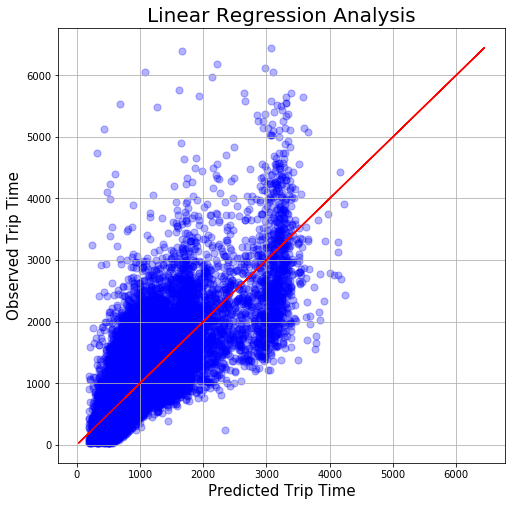

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Predicted Trip Time', fontsize = 15)
ax.set_ylabel('Observed Trip Time', fontsize = 15)
ax.set_title('Linear Regression Analysis', fontsize = 20)
ax.scatter( regr.predict(Xlin_test).reshape(-1,1), ylin_test, s = 50, alpha = .3, color = 'blue')
#ax.scatter(lin_data['is_rush_hour'],lin_data['travel_time'] )
ax.plot( ylin_test, ylin_test, color = 'red' )
ax.grid()

### We can see that this linear regression model has the same issue the Gradient Boosting and Random Forest models have with the big outliers on the upper end. This issue is kind of to be expected, there simply are more factors that would make a cab ride surprisingly long versus those that would make a cab ride surprisingly short.

This model doesn't do as well as the random forest model, in terms of predictive accuracy, although this regression model doesn't do particularly badly. After all, the $R^2$ of this regression model is only about .15 worse than the random forest. Although from looking at the plots of predicted vs actual values of both models, it seems clear that the RF model is capturing the general trends better. (although RF certainly takes more time to fit than the regression model)


## At this point, I am settling in on the idea of using a random forest model with a linear ajustment, as this seems to be doing the best. The features it places a high imporance on make sense to me, and the results generally seem to be good. The rmse suggests that it's usually off by a little more than five minutes, which isn't that bad.

## Below, I will try one more idea, which is to use PCA on trip data and make clusters of that, and see if that improves the model at all.

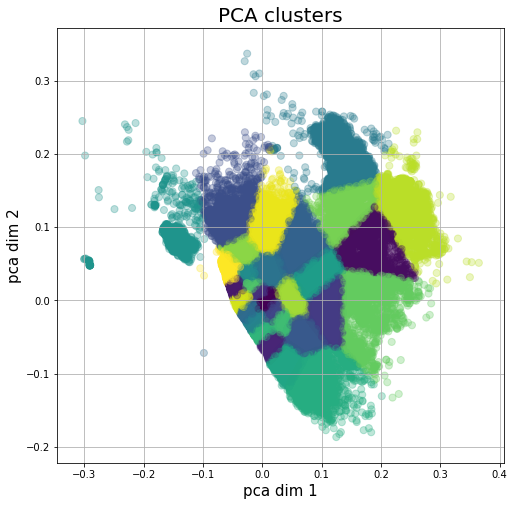

In [11]:
from sklearn.decomposition import PCA as PCA 

pca_2d = PCA(n_components=2)
pca_2d_coordinates = pca_2d.fit_transform(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])



K = 30 # change K to whatever number of clusters you want
kmeans_model = KMeans(n_clusters=K)

# perform K-means 
kmeans = kmeans_model.fit(pca_2d_coordinates)

# Get cluster labels for each data point
labels = kmeans.predict(pca_2d_coordinates)

df['PCA_clust'] = labels


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pca dim 1', fontsize = 15)
ax.set_ylabel('pca dim 2', fontsize = 15)
ax.set_title('PCA clusters', fontsize = 20)
ax.scatter( pca_2d_coordinates[:, 0], pca_2d_coordinates[:, 1], s = 50, alpha = .3, c = labels )
ax.grid()





train r squared: 0.9671750776196737
test R squared: 0.7489999764530876
test RMSE: 324.05530970984915
test RMSLE: 0.38434221471809715
None
1. feature 2 (0.674858)
2. feature 3 (0.101979)
3. feature 6 (0.057428)
4. feature 5 (0.051125)
5. feature 7 (0.050818)
6. feature 4 (0.041548)
7. feature 1 (0.013286)
8. feature 0 (0.008957)


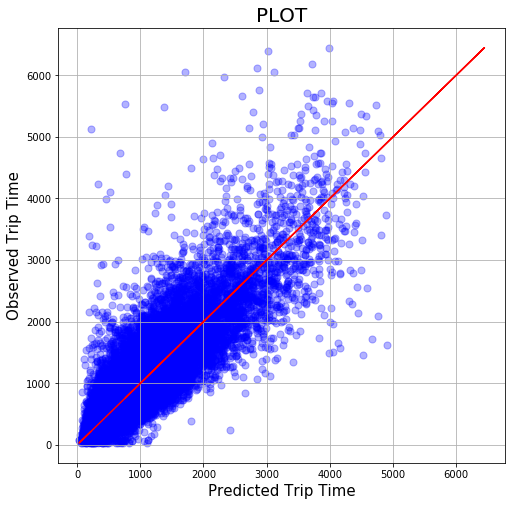

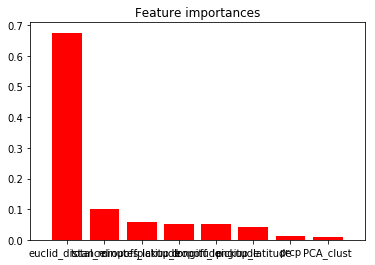

In [33]:

columns = ['PCA_clust', 'prcp','euclid_distance', 'total_minutes', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

deg = 1

linear_adjust(RandomForestRegressor(n_estimators = 50, max_depth = 30), df, columns, deg)

### From testing and fiddling around with the different functions and variables, I am going to settle on using a random forest model (and making a linear fit on the training residuals). As far as what variables to use, none of the clustering seemed to help much in terms of predictive performance, neither did incorporating the collision dataset. From looking at feature importances, the model will do rughly the same whether i do or don't inlude one of the distances, although incorporating euclid_distance seems to do the best. Other than than, the pickup and dropoff lattitudes did help (including them in the rf model makes sense), and taking into account the weekday and total minutes also help. This intuitively makes sense, although the weekday doesn't seem to matter as much as I thought it would. Finally, I will inlude the prcp variable form the wheather dataset, although it doesnt help that much.

### Doing this returns a RMSE of about 300 seconds, so roughly five minutes. This seems pretty good, especially since this includes mostly trips a lot longer than that (the r^2 is also pretty good, being in the upper .70s). We still see the model doesn't capture some big outliers, but there are plenty factors that could make a trip last much longer than expected, so this isn't too surprising. I don't expect to see the model do quite this well on the 2015 test data, but these results seem pretty good. 

## Will set n_estimators to 30, and max_depth to 30
## increasing the number of estimators helps, but does make the runtime take a while, so setting it to 30 feels like a good balance

('i =', 10)
train r squared: 0.9558315806909957
test R squared: 0.7726949554303074
test RMSE: 306.8357901363922
test RMSLE: 0.37280485623811116
None
1. feature 0 (0.668946)
2. feature 2 (0.101105)
3. feature 6 (0.053654)
4. feature 5 (0.049358)
5. feature 7 (0.047950)
6. feature 4 (0.038430)
7. feature 3 (0.029870)
8. feature 1 (0.010688)


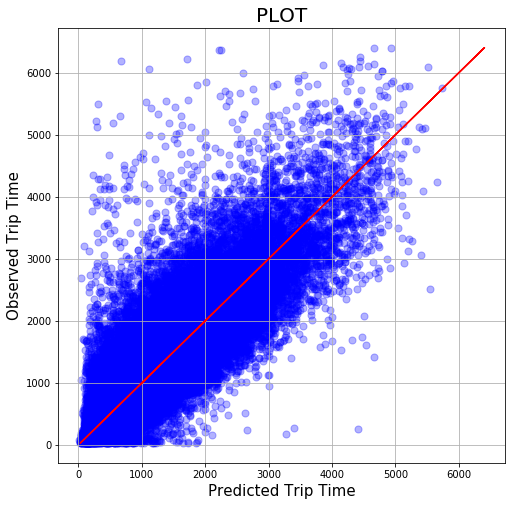

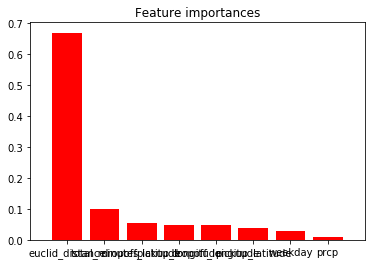

('i =', 20)
train r squared: 0.963023352411737
test R squared: 0.7837799508245367
test RMSE: 299.2605427986227
test RMSLE: 0.3631621825201553
None
1. feature 0 (0.669426)
2. feature 2 (0.100344)
3. feature 6 (0.053917)
4. feature 5 (0.049095)
5. feature 7 (0.048080)
6. feature 4 (0.038574)
7. feature 3 (0.029894)
8. feature 1 (0.010670)


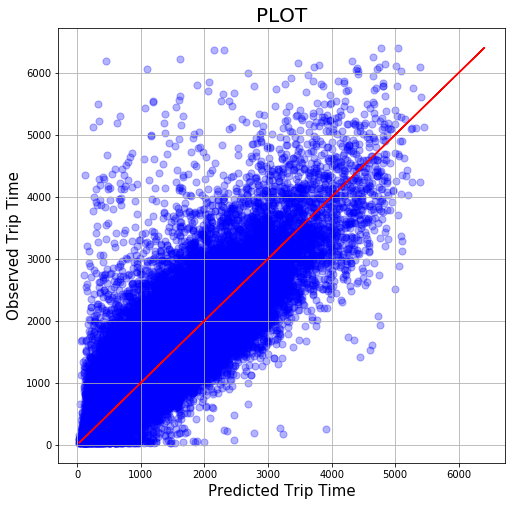

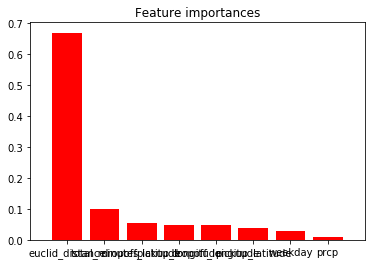

('i =', 30)
train r squared: 0.9651434410157521
test R squared: 0.787819436698328
test RMSE: 296.4519268372582
test RMSLE: 0.35956322764751625
None
1. feature 0 (0.669343)
2. feature 2 (0.100437)
3. feature 6 (0.053843)
4. feature 5 (0.048974)
5. feature 7 (0.048167)
6. feature 4 (0.038608)
7. feature 3 (0.029887)
8. feature 1 (0.010741)


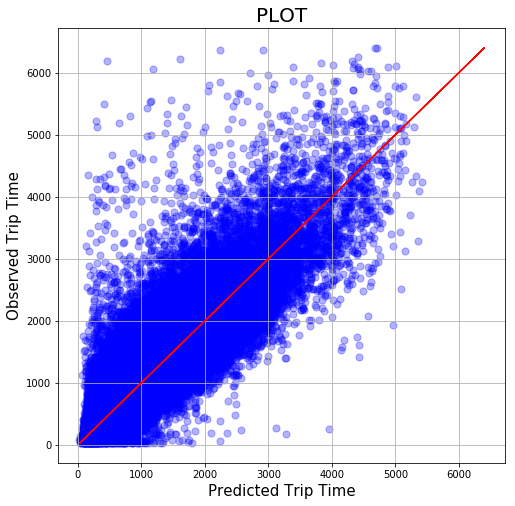

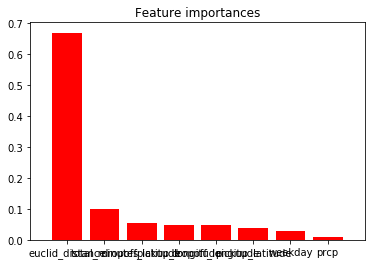

('i =', 50)
train r squared: 0.9670261647660091
test R squared: 0.7903960633638777
test RMSE: 294.6464384660588
test RMSLE: 0.3564017524431077
None
1. feature 0 (0.669386)
2. feature 2 (0.100408)
3. feature 6 (0.053814)
4. feature 5 (0.049200)
5. feature 7 (0.048011)
6. feature 4 (0.038605)
7. feature 3 (0.029863)
8. feature 1 (0.010712)


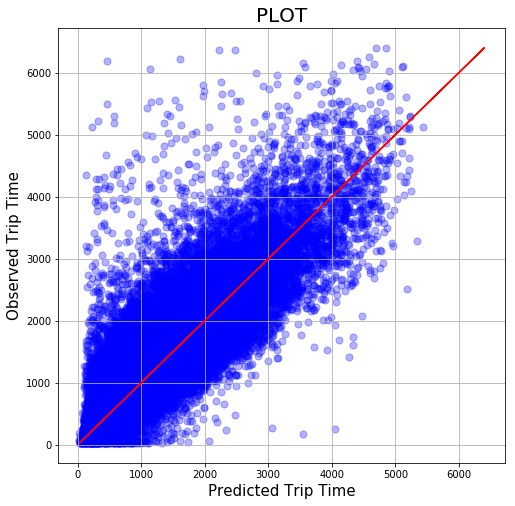

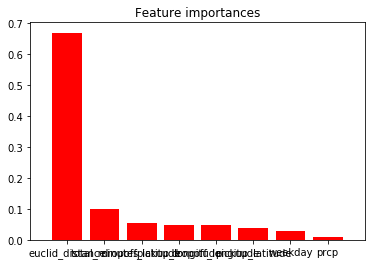

In [39]:

columns = ['euclid_distance','prcp','total_minutes', 'weekday', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

deg = 1 


for i in (10, 20, 30, 50):
    print('i =', i)
    linear_adjust(RandomForestRegressor(n_estimators = i, max_depth = 30), df, columns, deg)









## One last issue, since I can't do the bigquery ST_distance formula on the test csv file, i will instead \ calculate haversine distance in python. This won't change the performance. (it's probably faster calculating distance like this anyways)

In [21]:
a = np.sin((df['dropoff_latitude'] - df['pickup_latitude'] )*np.pi/360.0 )**2 + \
        np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * \
           np.sin( (df['dropoff_longitude']-df['pickup_longitude'])*np.pi/360.0)**2
#earth radius is approx. 6371 km           
df['dist'] = 6371. * 2. * np.arcsin(np.sqrt(a)) * 1000. #converting to m


train r squared: 0.9666976402728917
test R squared: 0.7904607917090173
test RMSE: 296.47256198545284
test RMSLE: 0.3565675912292342
None
1. feature 0 (0.677048)
2. feature 2 (0.096883)
3. feature 6 (0.054338)
4. feature 7 (0.045281)
5. feature 5 (0.044934)
6. feature 4 (0.040537)
7. feature 3 (0.029994)
8. feature 1 (0.010985)


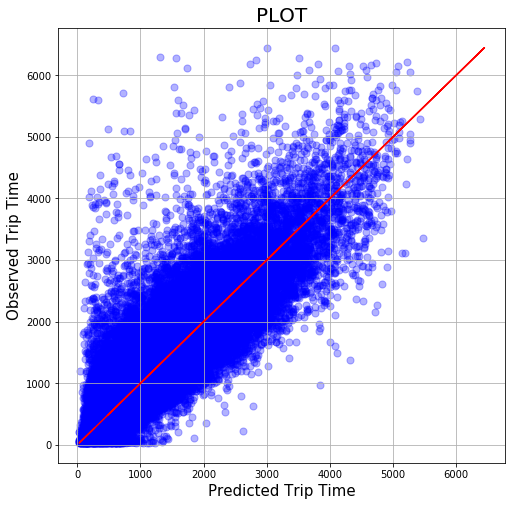

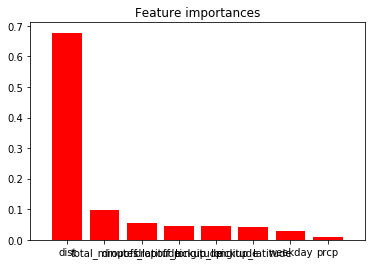

In [24]:
columns = ['dist','prcp','total_minutes', 'weekday', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

deg = 1 


linear_adjust(RandomForestRegressor(n_estimators = 30, max_depth = 30), df, columns, deg)